In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Preparing the data to be passed to mSHIFT**

This notebook performs all the steps required to produce the pandas dataframe with all data needed run scenarios in mSHIFT using NHANES data. This is the dataframe that is needed to input to the main code to run the simulation.

It is assumed that the following NHANES data files have been downloaded and are stored in a directory '/Data' which contains a seperate folder for each NHANES round "/2017", "/2015" and "/2013".  











Import necessary libraries

In [7]:
import random as rand
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import joblib
import math
import seaborn as sns


Enter working directory

In [2]:
%cd drive/My Drive/Meat_Microsimulation/

/content/drive/My Drive/Meat_Microsimulation


In [ ]:
!python -V

Python 3.10.12


# Preparing the non-dietary data

## Loading the raw data

In [5]:
years = {2017: '_J.XPT', 2015: '_I.XPT', 2013: '_H.XPT'}

datasets = {}
for year in years.keys():
  datasets[year] = {}

  datasets[year]['Dem_data'] = pd.read_sas('Data/'+str(year)+ '/DEMO' + years[year])
  datasets[year]['Alcohol_data'] = pd.read_sas('Data/'+str(year)+ '/ALQ' + years[year])
  datasets[year]['Smoking_data'] = pd.read_sas('Data/'+str(year)+ '/SMQ' + years[year])
  datasets[year]['BMI_data'] = pd.read_sas('Data/'+str(year)+ '/BMX' + years[year])
  datasets[year]['SBP_data'] = pd.read_sas('Data/'+str(year)+ '/BPX' + years[year])
  datasets[year]['HDL_data'] = pd.read_sas('Data/'+str(year)+ '/HDL' + years[year])
  datasets[year]['TChol_data'] = pd.read_sas('Data/'+str(year)+ '/TCHOL' + years[year])
  datasets[year]['BPQ_data'] = pd.read_sas('Data/'+str(year)+ '/BPQ' + years[year])
  datasets[year]['Blood_Glucose'] = pd.read_sas('Data/'+str(year)+ '/GLU' + years[year])
  datasets[year]['MV_data'] = pd.read_sas('Data/'+str(year)+ '/DSQTOT' + years[year])
  datasets[year]['Diabetes_data'] = pd.read_sas('Data/'+str(year)+ '/DIQ' + years[year])
  datasets[year]['MQ_data'] = pd.read_sas('Data/'+str(year)+ '/MCQ' + years[year])
  datasets[year]['Rep_data'] = pd.read_sas('Data/'+str(year)+ '/RHQ' + years[year])
  datasets[year]['Asp_data'] = pd.read_sas('Data/'+str(year)+ '/RXQASA' + years[year])
  datasets[year]['PA_data'] = pd.read_sas('Data/'+str(year)+ '/PAQ' + years[year])

Select the relevant NHANES variables from each of the datasets

In [ ]:
for year in years.keys():
  dem_data = datasets[year]['Dem_data']
  age_filter = (dem_data['RIDAGEYR'] > 17)   ## only want Adults in the simulation
  dem_data = dem_data.loc[age_filter]
  datasets[year]['Dem_data']  = dem_data[['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'DMDEDUC2', 'DMDEDUC3', 'INDHHIN2', 'WTINT2YR']]

  datasets[year]['BMI_data'] = datasets[year]['BMI_data'][['SEQN', 'BMXHT', 'BMXWT']]
  datasets[year]['SBP_data'] = datasets[year]['SBP_data'][['SEQN','BPXSY1']]
  datasets[year]['HDL_data'] = datasets[year]['HDL_data'][['SEQN','LBDHDD']]
  datasets[year]['TChol_data'] = datasets[year]['TChol_data'][['SEQN', 'LBXTC']]
  datasets[year]['Smoking_data'] = datasets[year]['Smoking_data'][['SEQN', 'SMQ040', 'SMD030', 'SMD650', 'SMD641']]
  datasets[year]['BPQ_data'] = datasets[year]['BPQ_data'][['SEQN', 'BPQ040A', 'BPQ020']]
  datasets[year]['MV_data'] = datasets[year]['MV_data'][['SEQN', 'DSD010']]
  datasets[year]['Diabetes_data'] = datasets[year]['Diabetes_data'][['SEQN', 'DIQ010']]
  datasets[year]['Blood_Glucose'] = datasets[year]['Blood_Glucose'][['SEQN', 'LBXGLU']]
  datasets[year]['MQ_data'] = datasets[year]['MQ_data'][['SEQN', 'MCQ300C','MCQ160A','MCQ160B', 'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ230A', 'MCQ230B']]
  datasets[year]['Rep_data'] = datasets[year]['Rep_data'][['SEQN', 'RHQ554', 'RHD143']]
  datasets[year]['Asp_data'] = datasets[year]['Asp_data'][['SEQN', 'RXQ515', 'RXQ520']]
  datasets[year]['PA_data'] =  datasets[year]['PA_data'][['SEQN','PAD680', 'PAD615', 'PAD630', 'PAD645', 'PAD660', 'PAD675']]

  if year == 2017:
    datasets[year]['Alcohol_data'] = datasets[year]['Alcohol_data'][['SEQN', 'ALQ130', 'ALQ111', 'ALQ121']]
  else:
    datasets[year]['Alcohol_data'] = datasets[year]['Alcohol_data'][['SEQN', 'ALQ130', 'ALQ101', 'ALQ120Q', 'ALQ120U', 'ALQ110']]

Combine the datasets from each year into a single dataframe.

In [ ]:
combined_data = {}

for key in datasets[year].keys():
  dfs = []
  for year in years.keys():
    dfs.append(datasets[year][key])

  combined_data[key] =pd.concat(dfs, axis = 0 )

combined_data_list = list(combined_data.items())
df = combined_data_list[0][1]

for i in range(len(combined_data_list)-1):
  df = pd.merge(df, combined_data_list[i+1][1], how='left', on='SEQN')

Set the SEQN variable to be the index of the dataframe

In [ ]:
df = df.set_index('SEQN')

Ensure that any NaN values that were previously replaced by an infinitessimally small float are set back to NaN

In [ ]:
for col in df.columns:
  cond = (df[col]<1e-10) & ((df[col]>0))
  if df[cond][col].count() > 0:
      df[col] = df[col].where(~cond, np.nan)

check the proportion of missing data for each variable

In [ ]:
df

,RIAGENDR,RIDAGEYR,RIDRETH3,DMDEDUC2,DMDEDUC3,INDHHIN2,WTINT2YR,ALQ130,ALQ111,ALQ121,...,RHQ554,RHD143,RXQ515,RXQ520,PAD680,PAD615,PAD630,PAD645,PAD660,PAD675
SEQN,,,,,,,,,,,,,,,,,,,,,
93705.0,2.0,66.0,4.0,2.0,NaN,3.0,8614.571172,1.0,1.0,7.0,...,1.0,NaN,2.0,NaN,300.0,NaN,NaN,NaN,NaN,60.0
93706.0,1.0,18.0,6.0,NaN,15.0,NaN,8548.632619,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,240.0,NaN,NaN,45.0,NaN,30.0
93708.0,2.0,66.0,6.0,1.0,NaN,6.0,13329.450589,NaN,2.0,NaN,...,NaN,NaN,NaN,2.0,120.0,NaN,NaN,NaN,NaN,30.0
93709.0,2.0,75.0,4.0,4.0,NaN,2.0,12043.388271,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,600.0,NaN,180.0,NaN,NaN,NaN
93711.0,1.0,56.0,6.0,5.0,NaN,15.0,11178.260106,1.0,1.0,5.0,...,NaN,NaN,1.0,NaN,420.0,NaN,NaN,60.0,60.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83723.0,1.0,61.0,1.0,2.0,NaN,10.0,11140.687817,2.0,NaN,NaN,...,NaN,NaN,NaN,1.0,360.0,NaN,NaN,NaN,NaN,30.0
83724.0,1.0,80.0,3.0,3.0,NaN,8.0,28323.849076,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,360.0,NaN,NaN,NaN,NaN,60.0
83726.0,1.0,40.0,1.0,1.0,NaN,9.0,45268.572702,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,360.0,NaN,NaN,NaN,120.0,NaN


In [ ]:
day2_data = pd.read_pickle('Data/mSHIFT_data_day2.plk')

In [ ]:
def nan_percentage(dataframe, column_name):
    """
    Calculates the percentage of NaN values in a specific column of a pandas DataFrame.

    :param dataframe: pandas DataFrame object.
    :param column_name: String representing the column name.
    :return: Percentage of NaN values in the column.
    """



    if column_name not in dataframe.columns:
        return "Column name not found in DataFrame."

    total_values = len(dataframe)
    nan_values = dataframe[column_name].isna().sum()

    return (nan_values / total_values) * 100

In [ ]:
df_unimputed_day2 = df[df.index.isin(day2_data.index)]

In [ ]:
nan_percentage(dataframe=df_unimputed_day2, column_name='LBDHDD')

4.8355452971725335

## Filling in some of the missing values

Replace the missing or refused data with 0 and re-label other integer valued variables. See the supplmentary material for a more detailed overview of the motivation for these choices.

In [ ]:
years_of_education_dict = {1: 8, 2: 10, 3: 12, 4: 14, 5: 16, 7: 13.5, 9: 13.5} ## Replace missing with weighted average (interview sample weight) value of 13.5
youth_education_variables = {13: 12, 14: 12, 15: 13, 55: 1, 66: 5, 77: 13.5, 99: 13.5}  ## ## Replace missing with average value
Income_variables = {12:5, 13:4, 14:11, 15:12, 77: 8, 99:8}
Smoker_variables = {1:1, 2:1, 3:0, 7:0, 9:0}
Parental_hist_variables = {1:1, 2:0, 9:0, 7:0}
alq_variables = {999.0: 0.68}

df['INDHHIN2'] = df['INDHHIN2'].fillna(value=8)   ## Relace missing values with approximate average household income
df = df.replace({'DMDEDUC2': years_of_education_dict})
df = df.replace({'DMDEDUC3': youth_education_variables})
df = df.replace({'INDHHIN2': Income_variables})
df = df.replace({'SMQ040': Smoker_variables})
df = df.replace({"MCQ300C": Parental_hist_variables})
df = df.replace({"ALQ130": alq_variables})





Ensure there were no errors with any nan values replaced by a float

In [ ]:
for col in df.columns:
  cond = (df[col]<1e-8) & ((df[col]>0))
  if df[cond][col].count() > 0:
    print(col)

Rename the columns to be more interpretable

In [ ]:
columns={"RIAGENDR": "Sex",
         "RIDAGEYR": "Age",
         "RIDRETH3": "Ethnicity",
         "DMDEDUC2":"Adult Years of Education",
         "DMDEDUC3":"Youth Years of Education",
         "INDHHIN2": "Annual Household Income",
         'WTINT2YR': 'Int Sample Weight',
         "BMXHT": "Height",
         "BMXWT":"Weight",
         "BPXSY1": "Systolic Blood Pressure",
         "LBDHDD": "HDL Cholesterol",
          "LBXTC": "Total Cholesterol",
         "MCQ300C": "Parental Diabetes History",
         "DIQ010": "Diabetes",
         "LBXGLU": "Blood Glucose",
         "DSD010": 'Taking Multivitamins'
         }

In [ ]:
df = df.rename(columns=columns)

In [ ]:

df['Adult Years of Education'] = df['Adult Years of Education'].fillna(df['Youth Years of Education'])  ## The missing data in the adult education column corresponds to those aged 18 or 19
df.pop('Youth Years of Education')
df = df.rename(columns = {'Adult Years of Education': 'Years of Education'})

Useful function -- returns the intersection of multiple lists

In [ ]:
def intersection(*lists):
    if(len(lists) <=1):
        return lists[0]

    intersection = lists[0]
    for i in range(1, len(lists)):
        intersection = set(intersection) & set(lists[i])

    return list(intersection)

Choose the NHANES years to include in the mSHIFT population. In the paper we choose only 2015 and 2017.

In [ ]:
simulation_years = [2017, 2015]

Now we take only those ids for whom we have dietary data and demographic data in the simulation.

In [ ]:
diet_data_2017_day2 = pd.read_sas('Data/2017/DR2IFF_J.XPT')
diet_data_2017 = pd.read_sas('Data/2017/DR1IFF_J.XPT')

In [ ]:
diet_data_2017 = pd.read_sas('Data/2017/DR1IFF_J.XPT')
diet_data_2015 = pd.read_sas('Data/2015/DR1IFF_I.XPT')
diet_data_2013 = pd.read_sas('Data/2013/DR1IFF_H.XPT')

diet_data_2017_day2 = pd.read_sas('Data/2017/DR2IFF_J.XPT')
diet_data_2015_day2 = pd.read_sas('Data/2015/DR2IFF_I.XPT')

combined_diet_data = pd.concat([diet_data_2017, diet_data_2015, diet_data_2013], axis = 0 )
combined_diet_data_day2 = pd.concat([diet_data_2017_day2, diet_data_2015_day2], axis = 0 )

In [ ]:
combined_diet_ids = []
combined_dem_ids = []

for year in simulation_years:
  diet_data = pd.read_sas('Data/'+str(year)+ '/DR1IFF' + years[year])
  diet_ids = set(diet_data['SEQN'].to_list())
  combined_diet_ids += diet_ids

  dem_ids = datasets[year]['Dem_data']['SEQN'].to_list()
  combined_dem_ids += dem_ids

sim_ids = intersection(combined_dem_ids, combined_diet_ids)
df = df[df.index.isin(sim_ids)]

print(f'Total number of individuals included in the simulation: {len(sim_ids)}')

Total number of individuals included in the simulation: 10248


Add the dietary sample weight to the dataframe. This is the sample weight used in mSHIFT

In [ ]:
def add_dietary_SW(row, diet_data, day: int):

  if day not in {1, 2}:
    raise ValueError('Day must be either 1 or 2 for day 1 or day 2 sample weigt respectively')

  SW_day = {1: 'WTDRD1',
            2: 'WTDR2D'}

  id = row.name
  dietary_SW = diet_data[diet_data['SEQN']==id].iloc[0,:][SW_day[day]]

  return dietary_SW

In [ ]:
df['Diet Sample Weight'] = df.apply(lambda row: add_dietary_SW(row, diet_data=combined_diet_data, day=1), axis=1)
df['Diet Sample Weight day 2'] = df.apply(lambda row: add_dietary_SW(row, diet_data=combined_diet_data, day=2), axis=1)

Divide the sample weight by the number of years included in the simulation.

In [ ]:
df['Diet Sample Weight'] = df['Diet Sample Weight']/len(simulation_years)
df['Diet Sample Weight day 2'] = df['Diet Sample Weight day 2']/len(simulation_years)

## Cleaning the dataframe ##

Functions that transform the variables in the dataframe to give a more meaningful interpretation, such as transforming appropriate variables into binary format.

In [ ]:
def Pregnant(row):

  pregnant = 0

  if row['RHD143'] == 1:
    pregnant = 1
  else:
    pass

  return pregnant

def Taking_Estrogen(row):

  taking_estrogen = 0

  if row['RHQ554'] == 1:
    taking_estrogen = 1
  elif row['RHQ554'] == 2:
    taking_estrogen = 0
  else:
    pass

  return taking_estrogen

def Smoker(row):

  ## Change between SMQ020/SMQ040 for alternative measure of whether someone smokes or not

  smoker = 0

  if row['SMQ040'] == 1 or row['SMQ040'] == 2:
    smoker = 1
  else:
    pass

  return smoker

def Smoker_ver2(row):

  smoker = math.nan

  if row['SMQ020'] == 1:
    smoker = 1
  elif row['SMQ020'] == 2:
    smoker = 0
  else:
    pass

  return smoker

def Starting_age(row):

  starting_age = math.nan

  if row['Current Smoker'] == 1:
    starting_age = row['SMD030']

  if starting_age == 999:
    starting_age = math.nan
  if starting_age == 777:
    starting_age = math.nan
  if starting_age < 1:
    starting_age = math.nan

  # if not math.isnan(row['SMD030']):
  #   if row['SMD030'] != 777 and row['SMD030'] != 999 and row['SMD030'] != 0:

  #   else:
  #     pass

  return starting_age

def Daily_cigarettes(row):

  daily_cigarettes = 0

  if row['Current Smoker']==1:
    daily_cigarettes = 11.2
    if not (math.isnan(row['SMD650']) and math.isnan(row['SMD641'])):
      if row['SMD650'] != 777 and row['SMD650'] != 999 and row['SMD641'] != 77 and row['SMD641'] != 99:
        days_smoked = row['SMD641']/30
        daily_cigarettes = days_smoked*row['SMD650']

  return daily_cigarettes

def smoking_pack_years(row):

  smoking_pack_years=0

  if row['Current Smoker']==1:
    years_smoking = row['Age']-row['Starting Age']
    daily_packets = row['Daily Cigarettes']/20
    smoking_pack_years = years_smoking*daily_packets

  return smoking_pack_years

def Hours_moderate_PA(row):

  mins_mod_PA = 0
  var_codes = ['PAD630', 'PAD645', 'PAD675']

  not_nan = False

  for variable in var_codes:
    if not math.isnan(row[variable]):
      not_nan = True
      break

  if not_nan:
    mins_mod_PA = 0
    for variable in var_codes:
        if not math.isnan(row[variable]):
           if row[variable] != 9999 and row[variable] != 7777:
              mins_mod_PA += row[variable]
           else:
              mins_mod_PA += 0

  hours_mod_PA = mins_mod_PA/60

  return hours_mod_PA

def Minutes_vigorous_PA(row):

  mins_vig_PA = math.nan
  var_codes = ['PAD660', 'PAD615']

  not_nan = False

  ## Check if there is a non-nan value ##

  for variable in var_codes:
    if not math.isnan(row[variable]):
      not_nan = True
      break

  if not_nan:
    mins_vig_PA = 0
    for variable in var_codes:
        if not math.isnan(row[variable]):
           if row[variable] != 9999 and row[variable] != 7777:
              mins_vig_PA += row[variable]
           else:
              mins_vig_PA = math.nan

  return mins_vig_PA


def Minutes_sed_activity(row):

  mins_sed_activity = math.nan

  if not math.isnan(row['PAD680']):
    if row['PAD680'] != 9999 and row['PAD680'] != 7777:
      mins_sed_activity = row['PAD680']
    else:
      pass

  return mins_sed_activity

def Drinker(row, year):

  drinker = 0

  if year == 2017:
    if row['ALQ111'] == 1:
      drinker = 1
    elif row['ALQ111'] == 2:
      drinker = 0
    else:
      pass

  elif year == 2015 or year == 2013:
    if row['ALQ110'] == 1:
      drinker = 1
    elif row['ALQ110'] == 2:
      drinker = 0
    elif (row['ALQ120Q'] != 777 or row['ALQ120Q'] != 999) and row['ALQ120Q'] > 0:
      drinker = 1
    else:
      pass

  return drinker

## Mapping unit codes to time scale

Alc_dict_2015 = {1:7, 2: 30, 3:365}
Alc_dict_2017 = {0: 1, 1:1, 2: 1, 3: 2, 4: 3.5, 5: 7, 6: 12, 7: 30, 8: 30, 9: 40.5, 10: 81, 11: 243}

def calculate_drinks(row, year):

  alc_drinks = math.nan

  if year==2017:
    if not math.isnan(row['ALQ130']) and not math.isnan(row['ALQ121']):
      if row['ALQ121'] != 99 and row['ALQ121'] != 77 and row['ALQ130'] != 999 and row['ALQ130'] != 777:
        alc_drinks = row['ALQ130']/Alc_dict_2017[int(row['ALQ121'])]
  else:
    if not math.isnan(row['ALQ130']) and not math.isnan(row['ALQ120U']):
          no_days_drinking = row['ALQ120Q']/Alc_dict_2015[int(row['ALQ120U'])]
          alc_drinks = row['ALQ130']*no_days_drinking

  return alc_drinks

def Taking_BPM(row):

  taking_BPM = 0

  if row['BPQ040A'] == 1:
    taking_BPM = 1
  elif row['BPQ040A'] == 2 or row['BPQ020'] == 2:
    taking_BPM = 0
  else:
    pass

  return taking_BPM

def Taking_Aspirin(row):

  taking_aspirin = 0

  if row['RXQ515'] == 1 or row['RXQ515'] == 3 or row['RXQ520']==1:
    taking_aspirin = 1
  elif row['RXQ515'] == 2 or row['RXQ515'] == 4 or row['RXQ520']==2:
    taking_aspirin = 0
  else:
    pass

  return taking_aspirin

def CVD(row):

  CVD = 0

  for string in ['D', 'B', 'E', 'F', 'C']:
      variable = row['MCQ160' + string]
      if variable == 1:
        CVD = 1

  return CVD

def Diabetes(row):

    diabetes = 0

    variable = row['Diabetes']
    #if Diabetes.notna().bool():

    if variable == 1:
        diabetes = 1
    else:
        pass


    blood_glucose = row['Blood Glucose']


    if not math.isnan(blood_glucose):
        blood_glucose = float(blood_glucose)
        if blood_glucose >= 126:
            diabetes = 1
        else:
            pass
    else:
        pass

    return diabetes

def CRC(row):

  CRC = 0

  CRC_1 = row['MCQ230A']
  CRC_2 = row['MCQ230B']

  for var in CRC_1, CRC_2:
    if not math.isnan(var):
      if int(var) == 16:
        CRC = 1
      elif int(CRC) == 31:
        CRC = 1
      else:
        pass
    else:
      pass

  return CRC

def calculate_BMI(row):
    BMI = row['Weight']/(row['Height']/100)**2
    return BMI

In [ ]:
df['Taking Estrogen'] = df.apply(lambda row: Taking_Estrogen(row), axis=1)
df['Current Smoker'] = df.apply(lambda row: Smoker(row), axis=1)
df['Starting Age'] = df.apply(lambda row: Starting_age(row), axis=1)
df['Daily Cigarettes'] = df.apply(lambda row: Daily_cigarettes(row), axis=1)
df['Smoking pack years'] = df.apply(lambda row: smoking_pack_years(row), axis=1)
df['Daily Drinks'] = df.apply(lambda row: calculate_drinks(row, year), axis=1)
df['Drinker'] = df.apply(lambda row: Drinker(row, year), axis=1)
df['Taking Aspirin'] = df.apply(lambda row: Taking_Aspirin(row), axis=1)
df['Taking BPM'] = df.apply(lambda row: Taking_BPM(row), axis=1)
df['CVD'] = df.apply(lambda row: CVD(row), axis=1)
df['CRC'] = df.apply(lambda row: CRC(row), axis=1)
df['Diabetes'] = df.apply(lambda row: Diabetes(row), axis=1)
df['Pregnant'] = df.apply(lambda row: Pregnant(row), axis=1)
df['Hours moderate physical activity'] = df.apply(lambda row: Hours_moderate_PA(row), axis=1)

df['Starting Age'] = df['Starting Age'].fillna(value=18)
df['Smoking pack years'] = df.apply(lambda row: smoking_pack_years(row), axis=1)
df['Parental Diabetes History'] = df['Parental Diabetes History'].fillna(value=0)



KeyError: ignored

Drop pregnant women from the population

In [ ]:
df = df.drop(df[df['Pregnant']==1].index)

## Random Forest Imputation of remaining variables ##

These random forests are pre-trained, with the training procedures available in the accompanying notebooks.

Load the random forest regressors

In [ ]:
Height_RF = joblib.load('Random_Forests/Height_RF.joblib')
Height_RF_Missing_Weight = joblib.load('Random_Forests/Height_RF_Weight_missing.joblib')
Weight_RF= joblib.load('Random_Forests/Weight_RF.joblib')
Weight_RF_Missing_Height = joblib.load('Random_Forests/Weight_RF_Height_missing.joblib')
Daily_Drinks_RF = joblib.load('Random_Forests/Daily_drinks_RF.joblib')
SBP_RF = joblib.load('Random_Forests/SBP_RF.joblib')
Total_chol_RF = joblib.load('Random_Forests/Total_cholesterol_RF.joblib')
HDL_chol_RF = joblib.load('Random_Forests/HDL_Chol_RF.joblib')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Functions that take impute the missing values in the dataframe using the random forest regressors

In [ ]:
def predict_height(row, RF, RF2):

  height = math.nan

  if math.isnan(row['Height']):
    if not math.isnan(row['Weight']):
      pred_array = np.array([row['Sex'], row['Age'], row['Ethnicity'], row['Years of Education'], row['Annual Household Income'], row['Weight']]).reshape(1,-1)
      height = float(RF.predict(pred_array))
      height = np.round(height, 1)
    else:
      pred_array = np.array([row['Sex'], row['Age'], row['Ethnicity'], row['Years of Education'], row['Annual Household Income']]).reshape(1,-1)
      height = float(RF2.predict(pred_array))
      height = np.round(height, 1)
  else:
    height  = row['Height']

  return height

def predict_weight(row, RF, RF2):

    weight = math.nan

    if math.isnan(row['Weight']):
      if not math.isnan(row['Height']):
        pred_array = np.array([row['Sex'], row['Age'], row['Ethnicity'], row['Years of Education'], row['Annual Household Income'], row['Height']]).reshape(1,-1)
        weight = float(RF.predict(pred_array))
        weight = np.round(weight, 1)
      else:
        pred_array = np.array([row['Sex'], row['Age'], row['Ethnicity'], row['Years of Education'], row['Annual Household Income']]).reshape(1,-1)
        weight = float(RF2.predict(pred_array))
        weight = np.round(weight, 1)
    else:
      weight  = row['Weight']

    return weight

def predict_daily_drinks(row, RF):

  daily_drinks = math.nan

  if math.isnan(row['Daily Drinks']):
    if row['Drinker'] == 0:
      daily_drinks = 0
    elif row['Drinker'] == 1:
      pred_array = np.array([row['Sex'], row['Age'], row['Height'], row['Weight'], row['Annual Household Income'], row['Years of Education'], row['Ethnicity']]).reshape(1,-1)
      try:
        daily_drinks = float(RF.predict(pred_array))
      except:
        print(pred_array)
  else:
    daily_drinks = row['Daily Drinks']

  return daily_drinks

def predict_SBP(row, RF):

  SBP = math.nan

  if math.isnan(row['Systolic Blood Pressure']):
    pred_array = np.array([row['Age'], row['Sex'], row['BMI']]).reshape(1,-1)
    SBP = float(RF.predict(pred_array))
  else:
    SBP = row['Systolic Blood Pressure']

  return SBP

def predict_total_cholesterol(row, RF):

  tot_chol = math.nan

  if math.isnan(row['Total Cholesterol']):
    pred_array = np.array([row['Age'], row['Sex'], row['BMI']]).reshape(1,-1)
    tot_chol = float(RF.predict(pred_array))
  else:
    tot_chol = row['Total Cholesterol']

  return tot_chol

def predict_HDL_cholesterol(row, RF):

  HDL_chol = math.nan

  if math.isnan(row['HDL Cholesterol']):
    pred_array = np.array([row['Age'], row['Sex'], row['BMI']]).reshape(1,-1)
    HDL_chol = float(RF.predict(pred_array))
  else:
   HDL_chol = row['HDL Cholesterol']

  return HDL_chol

In [ ]:
df['Height'] = df.apply(lambda row: predict_height(row, RF = Height_RF, RF2 = Height_RF_Missing_Weight), axis=1)
df['Weight'] = df.apply(lambda row: predict_weight(row, RF = Weight_RF, RF2 = Weight_RF_Missing_Height), axis=1)
df['BMI'] = df.apply(lambda row: calculate_BMI(row), axis=1)

df['Systolic Blood Pressure'] = df.apply(lambda row: predict_SBP(row, RF = SBP_RF), axis=1)
df['Total Cholesterol'] = df.apply(lambda row: predict_total_cholesterol(row, RF = SBP_RF), axis=1)
df['HDL Cholesterol'] = df.apply(lambda row: predict_HDL_cholesterol(row, RF = SBP_RF), axis=1)

df['Daily Drinks'] = df.apply(lambda row: predict_daily_drinks(row, RF = Daily_Drinks_RF), axis=1)

## Finalise the dataframe ##

Remove the NHANES variables that are no longer required.

In [ ]:
df.head()

,Sex,Age,Ethnicity,Years of Education,Annual Household Income,Int Sample Weight,ALQ130,ALQ111,ALQ121,ALQ101,...,Smoking pack years,Daily Drinks,Drinker,Taking Aspirin,Taking BPM,CVD,CRC,Pregnant,Hours moderate physical activity,BMI
SEQN,,,,,,,,,,,,,,,,,,,,,
93705.0,2.0,66.0,4.0,10.0,3.0,8614.571172,1.0,1.0,7.0,NaN,...,0.000000,0.0,0,0,1,0,0,0,1.00,31.725268
93706.0,1.0,18.0,6.0,13.0,8.0,8548.632619,NaN,2.0,NaN,NaN,...,0.000000,0.0,0,0,0,0,0,0,1.25,21.476821
93708.0,2.0,66.0,6.0,8.0,6.0,13329.450589,NaN,2.0,NaN,NaN,...,0.000000,0.0,0,0,1,0,0,0,0.50,23.714497
93711.0,1.0,56.0,6.0,16.0,12.0,11178.260106,1.0,1.0,5.0,NaN,...,0.000000,0.0,0,1,0,0,0,0,1.50,21.337009
93712.0,1.0,18.0,1.0,12.0,4.0,29040.496558,NaN,1.0,NaN,NaN,...,0.016667,0.0,0,0,0,0,0,0,4.50,19.725491


In [ ]:
irrelevant_variables = ['ALQ130', 'ALQ111', 'ALQ121', 'ALQ101', 'ALQ120Q', 'ALQ120U', 'ALQ110',
                        'SMQ040', 'SMD030', 'SMD650', 'SMD641',
                        'BPQ040A', 'BPQ020',
                        'RHQ554', 'RHD143',
                        'RXQ515', 'RXQ520',
                        'PAD680', 'PAD615', 'PAD630','PAD645', 'PAD660', 'PAD675',
                        'MCQ160A', 'MCQ160B', 'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ230A', 'MCQ230B',
                        'Blood Glucose']

In [ ]:
df = df.drop(irrelevant_variables, axis=1)

# Preparing the diet data (updated 06/01/2023)

This section of the notebook calculates the red and processed meat intake in grams for each individual within NHANES, before adjoining that data to the dataframe processed in the previous section which contains all non-dietary variables.

In [ ]:
diet_data_2015 = pd.read_sas('Data/2015/DR1IFF_I.XPT')
FPED_data_2015 = pd.read_pickle('Data/2015/FPED_2015.plk')

diet_data_2017 = pd.read_sas('Data/2017/DR1IFF_J.XPT')
FPED_data_2017 = pd.read_sas('Data/2017/fped_1718.sas7bdat')

In [ ]:
diet_data_2017_day2 = pd.read_sas('Data/2017/DR2IFF_J.XPT')
diet_data_2015_day2 = pd.read_sas('Data/2015/DR2IFF_I.XPT')

combined_diet_data_day2 = pd.concat([diet_data_2017_day2, diet_data_2015_day2], axis = 0 )

Remove unnecessary variables and rename the columns

In [ ]:
def simplify_diet_data(diet_data, day: int):

  if day not in {1, 2}:
    raise ValueError("day must be either 1 or 2")

  SW_day = {1: 'WTDRD1',
        2: 'WTDR2D'}

  diet_data = diet_data[['SEQN', SW_day[day], f'DR{day}IFDCD', f'DR{day}IGRMS', 'DRDINT']]

  diet_data_columns = {SW_day[day]: f'Diet Sample Weight day {day}',
                      f'DR{day}IFDCD': 'Food code',
                      f'DR{day}IGRMS': 'Grams',
                       'DRDINT': 'num_days_recall'}

  diet_data = diet_data.rename(columns=diet_data_columns)

  return diet_data

In [ ]:
diet_data_2017 = simplify_diet_data(diet_data_2017, day=1)
diet_data_2015 = simplify_diet_data(diet_data_2015, day=1)

In [ ]:
diet_data_2017_day2 = simplify_diet_data(diet_data_2017_day2, day=2)
diet_data_2015_day2 = simplify_diet_data(diet_data_2015_day2, day=2)

In [ ]:
diet_ids_2017 = set(diet_data_2017['SEQN'].to_list())
diet_ids_2015 = set(diet_data_2015['SEQN'].to_list())

diet_ids_2017_day2 = set(diet_data_2017_day2['SEQN'].to_list())
diet_ids_2015_day2 = set(diet_data_2015_day2['SEQN'].to_list())

The following function takes all the reported food codes of a single individual and returns the total intake of a given FPED variable. Red meat is PF_MEAT and processed meat is PF_CURED.

In [ ]:
FPED_data_2015 = FPED_data_2015.rename(columns={'V_STARCHY_TOTAL ': 'V_STARCHY_TOTAL'})

In [ ]:
diet_data_dictionary = {'2017': {
    1: {'diet data': diet_data_2017, 'FPED data': FPED_data_2017, 'ids': diet_ids_2017},
    2: {'diet data': diet_data_2017_day2, 'FPED data': FPED_data_2017, 'ids': diet_ids_2017_day2}
                                 },
                        '2015': {
    1: {'diet data': diet_data_2015, 'FPED data': FPED_data_2015, 'ids': diet_ids_2015},
    2: {'diet data': diet_data_2015_day2, 'FPED data': FPED_data_2015, 'ids': diet_ids_2015_day2}
                        }
}


In [ ]:
def intake_unconverted(row, variable, day, diet_data_dictionary):

  id = row.name

  for test_year in diet_data_dictionary.keys():
    if id in diet_data_dictionary[test_year][day]['ids']:
      year=test_year

  FPED_data = diet_data_dictionary[year][day]['FPED data']
  diet_data = diet_data_dictionary[year][day]['diet data']

  diet = diet_data[diet_data['SEQN']==id]
  food_codes = diet['Food code'].tolist()
  intake = 0

  for food_code in food_codes:

    unit_per_100g = float(FPED_data[FPED_data['FOODCODE']==food_code][variable])

    try:
      number_grams = float(diet[diet['Food code']==food_code]['Grams'])
    except:
      # Some respondents reported consuming the same food code twice
      number_grams = float(diet[diet['Food code']==food_code]['Grams'].sum())

    intake += unit_per_100g*(number_grams/100)

  return intake

In [ ]:
def intake(row, variable, day, diet_data_dictionary):

  id = row.name

  for test_year in diet_data_dictionary.keys():
    if id in diet_data_dictionary[test_year][day]['ids']:
      year=test_year

  FPED_data = diet_data_dictionary[year][day]['FPED data']
  diet_data = diet_data_dictionary[year][day]['diet data']

  diet = diet_data[diet_data['SEQN']==id]
  food_codes = diet['Food code'].tolist()
  intake = 0

  for food_code in food_codes:

    oz_per_100g = float(FPED_data[FPED_data['FOODCODE']==food_code][variable])

    try:
      number_grams = float(diet[diet['Food code']==food_code]['Grams'])
    except:
      # Some respondents reported consuming the same food code twice
      number_grams = float(diet[diet['Food code']==food_code]['Grams'].sum())

    intake += (oz_per_100g)*(number_grams/100)*28.35

  return intake

In [ ]:
df=pd.read_pickle('Data/mSHIFT_data_day2.plk')

In [ ]:

df['Processed meat intake day 1']=df.apply(lambda row: intake(row, variable='PF_CUREDMEAT',day=1, diet_data_dictionary=diet_data_dictionary), axis=1 )
df['Red meat intake day 1']=df.apply(lambda row: intake(row, variable='PF_MEAT', day=1, diet_data_dictionary=diet_data_dictionary), axis=1 )

In [ ]:
day2_ids = diet_ids_2017_day2.union(diet_ids_2015_day2)
df_day2 = df[df.index.isin(day2_ids)].copy()

In [ ]:
df_day2['Processed meat intake day 2']=df_day2.apply(lambda row: intake(row, variable='PF_CUREDMEAT',day=2, diet_data_dictionary=diet_data_dictionary), axis=1 )
df_day2['Red meat intake day 2']=df_day2.apply(lambda row: intake(row, variable='PF_MEAT', day=2, diet_data_dictionary=diet_data_dictionary), axis=1 )

Compute the average intake of each food group among those with tw days of dietary recall

In [ ]:
def average_intake(df, food_group):

  day1_intake = df.apply(lambda row: intake_unconverted(row, variable=food_group,day=1, diet_data_dictionary=diet_data_dictionary), axis=1 )
  day2_intake = df.apply(lambda row: intake_unconverted(row, variable=food_group,day=2, diet_data_dictionary=diet_data_dictionary), axis=1 )

  df[f"{food_group} intake"] = (day1_intake+day2_intake)/2

  return df

In [ ]:
FPED_data_2017.columns

Index(['FOODCODE', 'DESCRIPTION', 'F_TOTAL', 'F_CITMLB', 'F_OTHER', 'F_JUICE',
       'V_TOTAL', 'V_DRKGR', 'V_REDOR_TOTAL', 'V_REDOR_TOMATO',
       'V_REDOR_OTHER', 'V_STARCHY_TOTAL', 'V_STARCHY_POTATO',
       'V_STARCHY_OTHER', 'V_OTHER', 'V_LEGUMES', 'G_TOTAL', 'G_WHOLE',
       'G_REFINED', 'PF_TOTAL', 'PF_MPS_TOTAL', 'PF_MEAT', 'PF_CUREDMEAT',
       'PF_ORGAN', 'PF_POULT', 'PF_SEAFD_HI', 'PF_SEAFD_LOW', 'PF_EGGS',
       'PF_SOY', 'PF_NUTSDS', 'PF_LEGUMES', 'D_TOTAL', 'D_MILK', 'D_YOGURT',
       'D_CHEESE', 'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS'],
      dtype='object')

Analysis of the average daily intake of all other food groups in NHANES

In [ ]:
food_groups = [ 'F_TOTAL', 'F_CITMLB', 'F_OTHER', 'F_JUICE',
       'V_TOTAL', 'V_DRKGR', 'V_REDOR_TOTAL', 'V_REDOR_TOMATO',
       'V_REDOR_OTHER', 'V_STARCHY_TOTAL', 'V_STARCHY_POTATO',
       'V_STARCHY_OTHER', 'V_OTHER', 'V_LEGUMES', 'G_TOTAL', 'G_WHOLE',
       'G_REFINED', 'PF_TOTAL', 'PF_MPS_TOTAL', 'PF_MEAT', 'PF_CUREDMEAT',
       'PF_ORGAN', 'PF_POULT', 'PF_SEAFD_HI', 'PF_SEAFD_LOW', 'PF_EGGS',
       'PF_SOY', 'PF_NUTSDS', 'PF_LEGUMES', 'D_TOTAL', 'D_MILK', 'D_YOGURT',
       'D_CHEESE', 'OILS', 'SOLID_FATS', 'ADD_SUGARS', 'A_DRINKS']

for fg in food_groups:
  df = average_intake(df=df, food_group=fg)
  pop_avg_intake = (df[f'{fg} intake']*df['Sample Weight']).sum() / df['Sample Weight'].sum()
  print(f'{fg}: {pop_avg_intake}')


F_TOTAL: 1.047052696591536
F_CITMLB: 0.26425843124749626
F_OTHER: 0.5224927075874389
F_JUICE: 0.2603015577566012
V_TOTAL: 1.6442312316661167
V_DRKGR: 0.17743079639792367
V_REDOR_TOTAL: 0.41277449763554325
V_REDOR_TOMATO: 0.30582900377551814
V_REDOR_OTHER: 0.10694549386002515
V_STARCHY_TOTAL: 0.46226855150982676
V_STARCHY_POTATO: 0.38781521318548323
V_STARCHY_OTHER: 0.07445333832434345
V_OTHER: 0.5917573861228232
V_LEGUMES: 0.13360883079079752
G_TOTAL: 6.853717296294543
G_WHOLE: 0.9780423760115047
G_REFINED: 5.875674920283038
PF_TOTAL: 6.688706050746422
PF_MPS_TOTAL: 5.02238317338943
PF_MEAT: 1.6466774323706936
PF_CUREDMEAT: 1.025238093132005
PF_ORGAN: 0.015836375960785364
PF_POULT: 1.7145274080411408
PF_SEAFD_HI: 0.1753527911307433
PF_SEAFD_LOW: 0.4447510727540625
PF_EGGS: 0.6278722612259124
PF_SOY: 0.1317690590905542
PF_NUTSDS: 0.9066815570405246
PF_LEGUMES: 0.5353042989921707
D_TOTAL: 1.7564897960342547
D_MILK: 0.8377076133172999
D_YOGURT: 0.07950630751988795
D_CHEESE: 0.786896689672

# Finalising the data

Final step is to intialise the variables that keep track of the bumber of new disease cases, mortalities with a disease and total mortalities throughout the duration of the simulation.

Note here we create a new variable "Sample Weight", copied from the Diet Sample Weight, that is updated to account for mortalities during the simulation.

We also compute the proportion of those who do not have any disease. At the start of the simulation this is equivilent to those that do not start with any mong 'Diabetes', 'CVD' or 'CRC' equal to one.



In [ ]:
def healthy_pop(row):

    healthy = 0

    if row['Diabetes'] == 1 or row['CVD'] == 1 or row['CRC'] == 1:
        pass
    else:
        with_disease = row['New diabetes cases'] + row['New CVD cases'] + row['New CRC cases'] - row['New diabetes and CVD cases'] - row['New diabetes and CRC cases'] - row['New CVD and CRC cases'] + row['New diabetes and CVD and CRC cases']
        healthy = row['Sample Weight'] - with_disease

    return healthy

In [ ]:
def prep_df(df, day):

    df['New diabetes cases'] = 0
    df['New CVD cases'] = 0
    df['New CRC cases'] = 0
    df['New diabetes and CVD cases'] = 0
    df['New diabetes and CRC cases'] = 0
    df['New CVD and CRC cases'] = 0
    df['New diabetes and CVD and CRC cases'] = 0
    df['Sample Weight'] = df[f'Diet Sample Weight day {day}']

    df['healthy'] = df.apply(lambda row: healthy_pop(row), axis=1)

    return df

In [ ]:
df['Diet Sample Weight day 2']

SEQN
93705.0    2.820196e+03
93706.0    2.698803e-79
93708.0    1.124093e+04
93711.0    4.114980e+03
93712.0    4.453321e+04
               ...     
93691.0    4.944811e+03
93695.0    1.688498e+04
93696.0    3.123771e+04
93697.0    4.677873e+04
93702.0    2.758347e+04
Name: Diet Sample Weight day 2, Length: 10158, dtype: float64

In [ ]:
df = prep_df(df, day=1)

In [ ]:
df_day2 = prep_df(df_day2, day=2)

Perform a final check to make sure there are no missing data

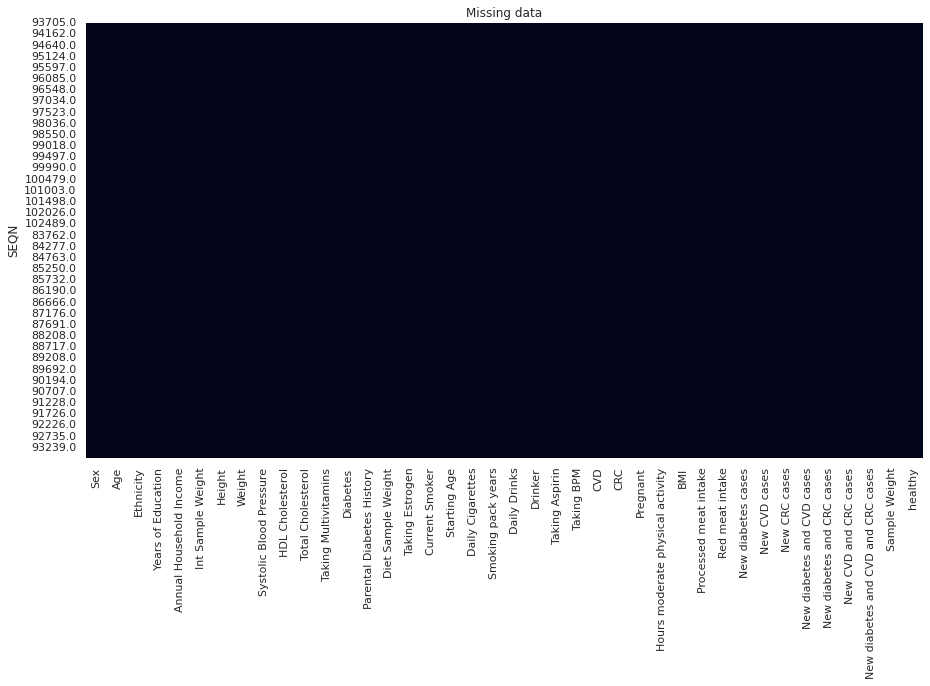

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing data")
plt.show()

If there are no missing then data, then save the dataframe as a pickle object. This will then be passed to mSHIFT.

In [ ]:
df.to_pickle(path='Data/mSHIFT_data.plk')

In [ ]:
df_day2.to_pickle(path='Data/mSHIFT_data_day2.plk')